### What drives the success of lower budget movies? 
Can we use linear regression to identify the features of lower budget movies that drive success?


In [1]:
# storing
import pickle

# exploratory analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from pandas.tools.plotting import scatter_matrix
import math

# regression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import train_test_split


from pprint import pprint

%matplotlib inline

### Parse movie data retrieved from IMDb

First, let's load the movie data into a dataframe and do some column cleanup.

In [2]:
movies = pd.read_csv('data/IMDb.csv', header=0)

In [3]:
drop_cols = ['movie_title', 'plot_keywords', 'movie_imdb_link', 'title_year']
catigory_drop_cols = ['color', 'director_name', 'actor_2_name', 'genres','actor_1_name', 'actor_3_name', 'language', 'country', 'content_rating']
 
# drop unnecessary cols
movies.drop(drop_cols, axis = 1, inplace = True)
movies.dropna(inplace=True)

In [4]:
# delete or move to later 
by_genre = movies.groupby('genres')
by_rating = movies.groupby('content_rating')
by_country = movies.groupby('country')

Next, let's aggregate the given parameters for some of the categorical features (season, genre, MPAA rating) into more succinct paramaters for use in the analysis.

In [5]:
def recat(df, func, new_col, old_col):
    '''Recategorize variable in new column based on data in old col
    and provided function. 
    Args: 
    df -- data frame
    func -- function to apply
    new_col (str) -- name of new column (to store result of function)
    old_col (str) -- name of old column (on which to apply function)
    '''
    df[new_col] = df.loc[:, old_col].apply(func) 


# trim raw genres to simple genres
def get_simple_genre(g):
    '''Recategorize raw genre into simple genre.'''
    slimed = g.split('|')[:3]
    return '|'.join(slimed)


In [6]:
recat(movies, get_simple_genre, 'new_genres', 'genres')

### Subset data to movies with gross information and parse

Since we're interested in budget data, let's check to see how many movies of the total movies have budget data.

In [7]:
movies.gross.count()

3770

### Adjust budgets to 2016 dollars 

In [8]:

def get_infl_rate(startyear, endyear):
    '''Return inflation rate to 2016 dollars. 
    Args:
    startyear (float) -- start year
    endyear (int) -- end year
    Returns:
    infl (float) -- inflation rate
    '''
    cpi = pd.read_csv('data/cpi-data.csv')
    cpi.set_index('YEAR', inplace = True)
    if endyear > 2015:
        return float('NaN')
    else:
        try:
            cpiend = float(cpi.loc[endyear, 'AVE.'])
            cpistart = float(cpi.loc[int(startyear), 'AVE.'])
            infl = ((cpiend - cpistart) / cpistart) 
            return (1.0 + infl)
        except:
            return float('NaN')
    
def add_infl_rate(df):
    # add release year
    try:
        df['release_year'] = df.loc[:,'release_date'].apply(lambda x: x.year)
    except:
        df['release_year'] = None
    df['infl_rate'] = df.loc[:,'release_year'].apply(get_infl_rate, args=(2015,))
    
def add_adj_budget(df):
    df['budget_adj'] = df.loc[:, 'budget'] * df.loc[:, 'infl_rate']
    df['budget_adj'] = df.loc[:,'budget_adj'].fillna(0.0).astype(int)


In [9]:
add_infl_rate(movies)
add_adj_budget(movies)

### Explore high-level features

Now that our base data has been parsed, let's explore the high-level relationship between movie success and our continuous features.

**Domestic total gross vs. features**

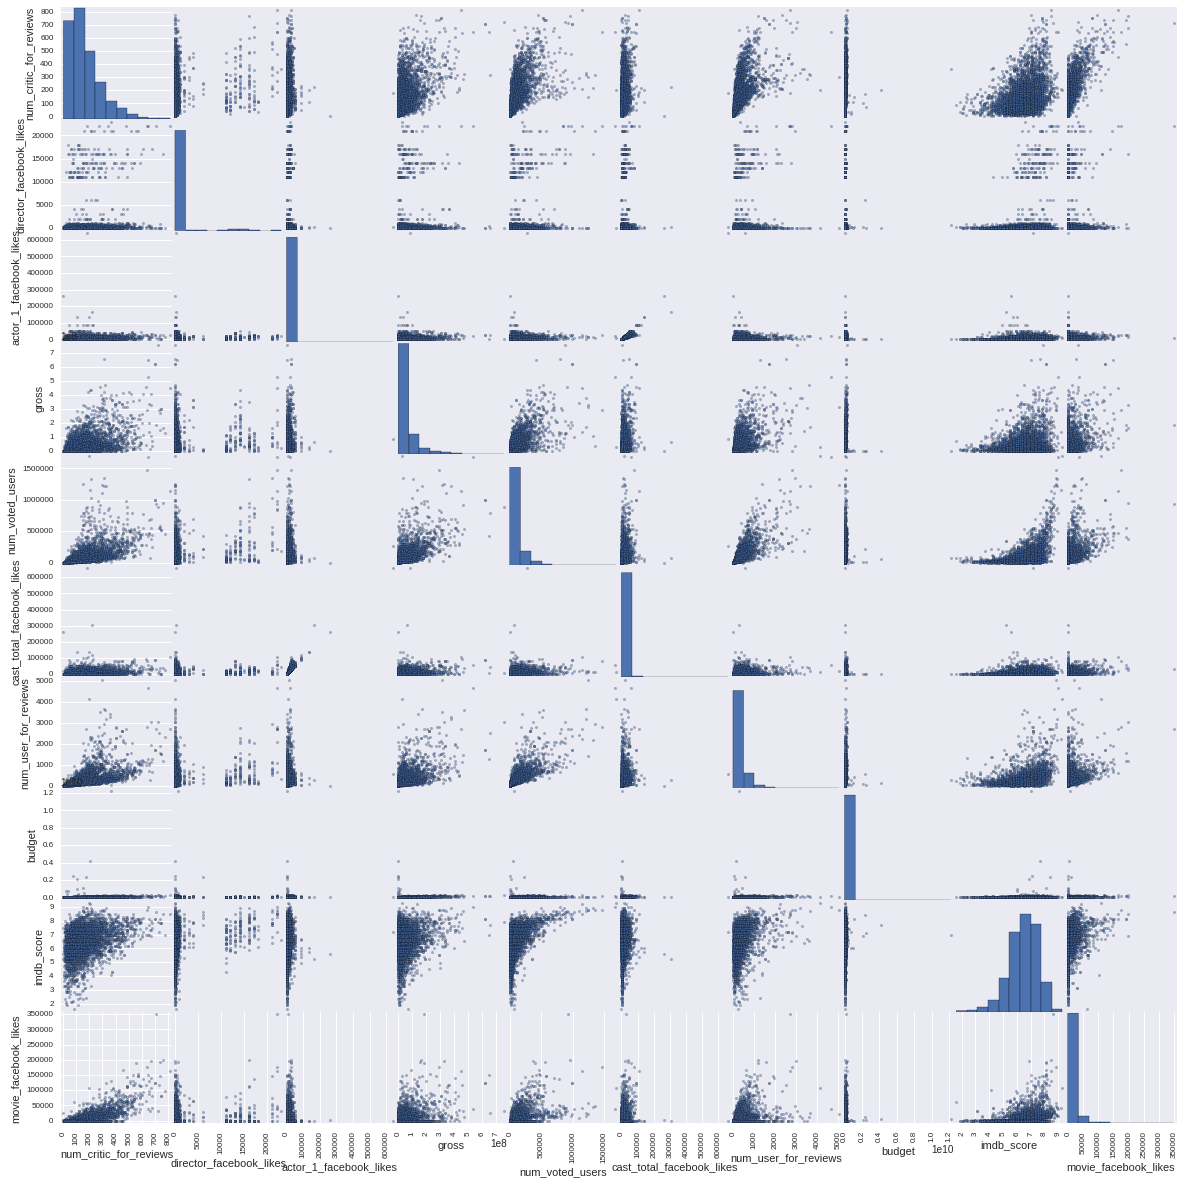

In [10]:
gross_features = ['num_critic_for_reviews', 'director_facebook_likes',
                  'actor_1_facebook_likes', 'gross', 'num_voted_users', 'cast_total_facebook_likes',
                  'num_user_for_reviews', 'budget', 'imdb_score', 'movie_facebook_likes']

scatter_matrix(movies[gross_features], figsize = (20, 20), alpha = 0.5, diagonal='hist')

plt.show()

In [11]:
# log transform the gross
def log_transform(stat):
    if stat > 0:
        return math.log(stat)
    elif stat == 0:
        return math.log(stat + .001)
    else:
        return math.log(1 + stat)
    
recat(movies, log_transform, 'gross_log', 'gross')
recat(movies, log_transform, 'budget_log', 'budget')

From these initial scatter plots, we can see that some of the fields are not normally distributed and will need to be normalized by taking the logarithm. Some also have skewed distributions, but normalization of these features will depend on model performance.

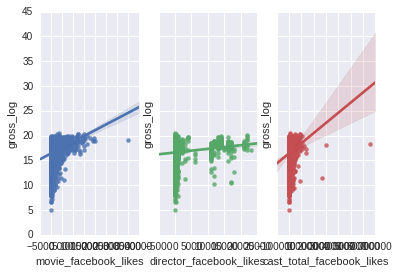

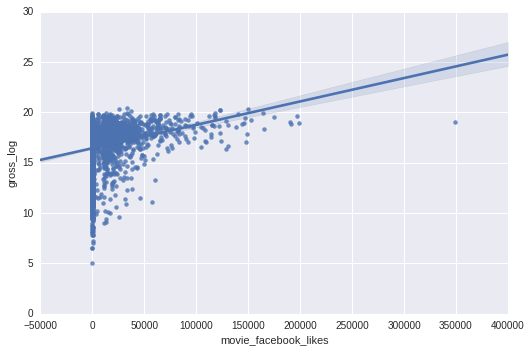

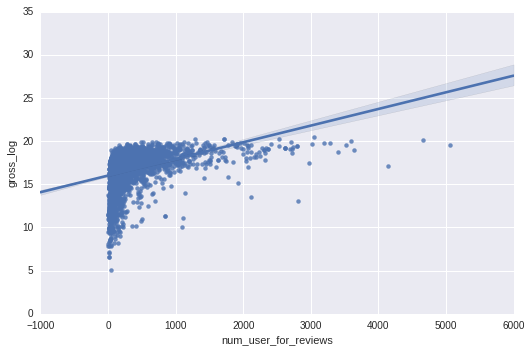

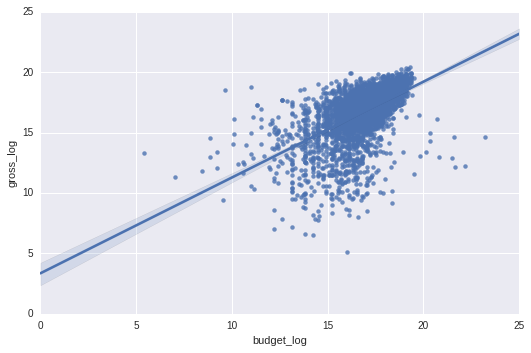

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True)
sns.regplot(x=movies['movie_facebook_likes']/10, y=movies['gross_log'], ax=ax1)
sns.regplot(x=movies['director_facebook_likes'], y=movies['gross_log'], ax=ax2)
sns.regplot(x=movies['cast_total_facebook_likes'], y=movies['gross_log'], ax=ax3)

sns.lmplot('movie_facebook_likes', 'gross_log', movies, size=5, aspect=1.5)
sns.lmplot('num_user_for_reviews', 'gross_log', movies, size=5, aspect=1.5)
sns.lmplot('budget_log', 'gross_log', movies, size=5, aspect=1.5)
# plt.title('movie_facebook_likes vs. gross_log', fontsize=16)
# plt.xlabel('movie_facebook_likes', fontsize=14)
# plt.ylabel('gross_log', fontsize=14)
# plt.savefig('presentation/lmplot-theaters.png')
plt.show()

### FB > $

To be honest, I am not sure if I did it right, but it would seem that your production budget does not really corelate well with your gross, but total FB likes is a great predictor. However, when I changed it to be the log of the gross vs log of budget it seemed to work out better.


**Gross revenues model**  
Like in the oscar nominations model, I found the following features and their subsets to be statistically significant in having predictive power in the revenues model:  
* rating: NC-17 vs. G, PG, PG-13, or R
* genres: horror, drama, foreign, or family vs. others

The functions below recategorize my features into these categories for my optimized model. I also normalize the gross revenues and theaters features as discussed in the previous section. 

### Split data for cross-validation

In [13]:
# split into train and test
train, test = train_test_split(movies, test_size = 0.3)

In [14]:
# check percentages
print 'train as % of total: ', float(train.shape[0]) / float(movies.shape[0])
print 'test as % of total: ', float(test.shape[0]) / float(movies.shape[0])

train as % of total:  0.7
test as % of total:  0.3


### Set up functions for regression

In [15]:
def get_xy(features, ind, df):
    '''Get X and y for use in skl linear regression.'''
    X = df[features]
    y = df[ind]
    return X, y

def regress_skl(X, y):  
    '''Fit linear regression model using skl.
    Prints rsq and intercept and returns model.'''
    # fit model
    m = LinearRegression()
    m.fit(X, y)
    coefs = zip(X.columns, m.coef_)
    rsq = m.score(X, y)
    intercept = m.intercept_
    print 'rsquared: ', rsq
    print 'intercept: ', intercept
    return m

def test_model(model, X_test, y_test, X, y):
    '''Generate predicted values for test set and compute mean squared
    error vs. training set.
    Returns for the test set: residuals, mse, ypred values. 
    Args:
    model -- fitted linear regression model to use for predictions
    X, y -- X, y of training set
    X_test, y_test = X, y of test set 
    '''
    test_ypred = model.predict(X_test)
    test_resid = y_test - test_ypred
    test_mse = mean_squared_error(y_test, test_ypred)
    
    train_ypred = model.predict(X)
    train_resid = y - train_ypred
    train_mse = mean_squared_error(y, train_ypred)
    print 'train mse: ', train_mse, 'vs. test mse: ', test_mse
    return test_resid, test_mse, test_ypred

def plot_qq(resid):
    '''Create QQ plot given model residuals.'''
    stats.probplot(resid, dist="norm", plot=plt)
    plt.show()

def cross_validate_mse(X, y, folds):
    '''Cross validate model. Returns mean mse.'''
    scores = cross_validation.cross_val_score(LinearRegression(), X, y, scoring='mean_squared_error', cv=folds)
    return scores.mean()

def cross_validate(X, y, folds):
    '''Cross validate model. Returns mean r-squared.'''
    scores = cross_validation.cross_val_score(LinearRegression(), X, y, cv=folds)
    return scores.mean()

In [16]:
def get_rsq4plot(features, ind, df):
    """Get list of adjusted rsquares based on number
    of features included.
    Args:
    features (list) -- list of features
    ind (str) -- column name of independent var
    df (df) -- df
    Returns:
    list of (num features, adjusted r squared tuples)
    """
    adj_rsqs = []
    feats = []
    for i in range(1, len(features)):
        feats.append(features[:i+1])
    for feat in feats:
        X, y = get_xy(feat, ind, df)
        model = sm.OLS(y, X)
        model = model.fit()
        adj_rsqs.append(model.rsquared_adj)
    return (map(lambda x: len(x), feats), adj_rsqs)  

def get_mse4plot(features, ind, df):
    """Get list of average mse from crossvalidation based on number
    of features included.
    Args:
    features (list) -- list of features
    ind (str) -- column name of independent var
    df (df) -- df
    Returns:
    list of (num features, average mse tuples); note that 
    first pair is for the intercept only 
    """
    avg_mse = []
    feats = []
    for i in range(1, len(features)):
        feats.append(features[:i+1])
    for feat in feats:
        X, y = get_xy(feat, ind, df)
        avg_mse.append(cross_validate_mse(X, y, 5))
    return (map(lambda x: len(x), feats), map(lambda x: abs(x), avg_mse))    

### Run domestic total gross model

In [ ]:
features = [ 'num_critic_for_reviews', 'director_facebook_likes', 
            'actor_3_facebook_likes', 'actor_1_facebook_likes',  
            'num_voted_users', 'cast_total_facebook_likes',  
            'num_user_for_reviews', 'budget', 'actor_2_facebook_likes', 'imdb_score', 
            'aspect_ratio', 'movie_facebook_likes']

target = 'gross_log'
X, y = get_xy(features, target, train)
gross = sm.OLS(y, X)
gross = gross.fit()
gross.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              gross_log   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     8556.
Date:                Tue, 01 Nov 2016   Prob (F-statistic):               0.00
Time:                        10:42:04   Log-Likelihood:                -6315.1
No. Observations:                2639   AIC:                         1.265e+04
Df Residuals:                    2627   BIC:                         1.272e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
num_critic_for_reviews        0.0046      0.001      6.672      0.000         0.003     0.006
director_facebook_likes   -3.334e-05   1.94e-05     -1.723      0.085     -7.13e-05  4.61e-06
actor_3_facebook_likes       -0.0006   8.07e-05     -6.837      0.000        -0.001    -0.000
actor_1_facebook_likes       -0.0004   4.83e-05     -9.246      0.000        -0.001    -0.000
num_voted_users           -1.101e-06   6.43e-07     -1.714      0.087     -2.36e-06  1.59e-07
cast_total_facebook_likes     0.0004   4.82e-05      9.323      0.000         0.000     0.001
num_user_for_reviews          0.0008      0.000      3.520      0.000         0.000     0.001
budget                     2.472e-12      2e-10      0.012      0.990     -3.91e-10  3.96e-10
actor_2_facebook_likes       -0.0004   5.23e-05     -8.426      0.000        -0.001    -0.000
imdb_score                    1.3815      0.036     37.955      0.000         1.310     1.453
aspect_ratio                  3.0450      0.107     28.337      0.000         2.834     3.256
movie_facebook_likes      -2.215e-05   3.74e-06     -5.927      0.000     -2.95e-05 -1.48e-05
==============================================================================
Omnibus:                     1674.080   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           110125.464
Skew:                          -2.253   Prob(JB):                         0.00
Kurtosis:                      34.324   Cond. No.                     5.73e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.73e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1]:
# get average rsquared and mse of cross-validation sets 
print 'avg rsq: ', cross_validate(X, y, 5)
print 'avg mse: ', cross_validate_mse(X, y, 5)

avg rsq: 

NameError: name 'cross_validate' is not defined

Let's run on our test set.

In [3]:
Xtest, ytest = get_xy(features_gross, ind, test)
gresid, gmse, gpred = test_model(gross, Xtest, ytest, X, y)

NameError: name 'features_gross' is not defined

MSE of 1.17 on the test set vs. 1.85 on the training set--the model actually performed better on the training set than the test set!

In [259]:
# compare actual vs. predictions
d_gross = {'pred': gpred, 'actual': ytest}
pd.DataFrame(d_gross).head()

,actual,pred
27,17.757011,17.367749
81,16.766172,17.353102
229,18.035692,18.353451
333,13.708816,14.017488
446,16.506849,18.364590


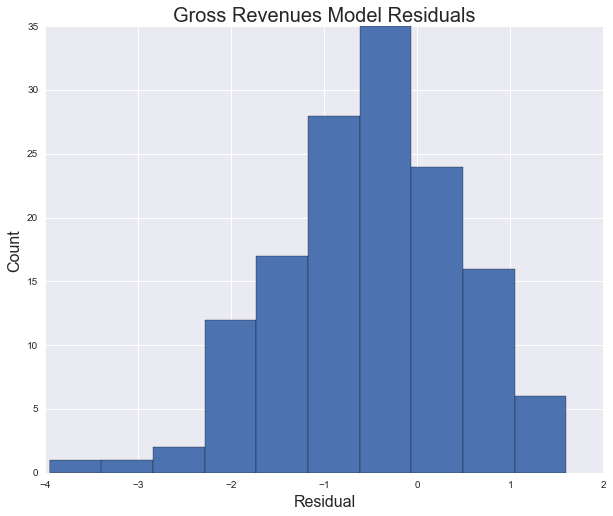

In [193]:
# plot historgram of residuals 
plt.figure(figsize=(10, 8))
plt.hist(gresid.values)
plt.title('Gross Revenues Model Residuals', fontsize=20)
plt.xlabel('Residual', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.savefig('presentation/gross-resid-hist.png')
plt.show()

In [255]:
numfeat_gross, mses_gross = get_mse4plot(features_gross, 'dadj_gross_log', train)
numfeat_gross2, rsqs_gross = get_rsq4plot(features_gross, 'dadj_gross_log', train)

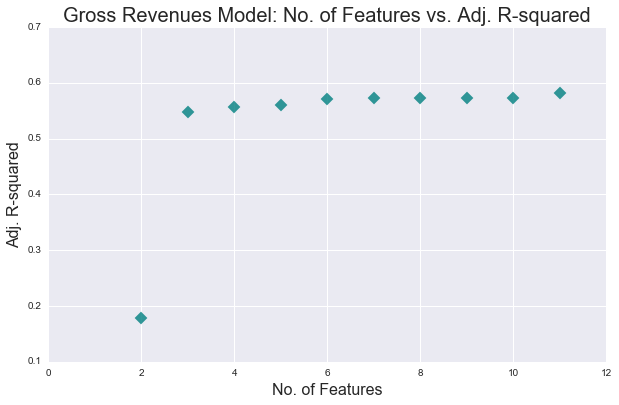

In [261]:
# plot rsq vs. num features
plt.figure(figsize=(10, 6))
plt.scatter(numfeat_gross2, rsqs_gross, s=75, color='teal', marker='D', alpha=0.8)
plt.title('Gross Revenues Model: No. of Features vs. Adj. R-squared', fontsize=20)
plt.xlabel('No. of Features', fontsize=16)
plt.ylabel('Adj. R-squared', fontsize=16)
plt.savefig('presentation/gross-plot.png')
plt.show()

train mse:  1.85480725064 vs. val mse:  1.85480725064


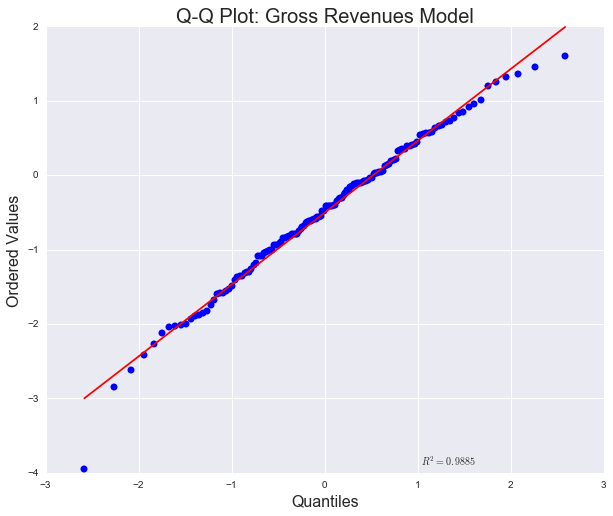

In [293]:
gtrain_resid, _, _ = validate(gross, X, y, X, y)

plt.figure(figsize=(10, 8))
stats.probplot(gresid, dist="norm", plot=plt)
plt.title('Q-Q Plot: Gross Revenues Model', fontsize=20)
plt.xlabel('Quantiles', fontsize=16)
plt.ylabel('Ordered Values', fontsize=16)
# plt.savefig('presentation/qq-gross.png')
plt.show()